# Дискретные случайные процессы и временные ряды.
## Задание 3.12
### Нейросетевой подход в анализе временных рядов.

Выполненную работу нужно отправить телеграм-боту  `@miptstats_ad21_bot`
* Дедлайн см. в телеграм-боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* По практическим задачам прислать нужно ноутбук.
* Теоретические задачи необходимо оформить в tex’е и прислать `pdf` или же прислать фотку в правильной ориентации рукописного решения, где все четко видно.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Не забывайте делать пояснения и выводы.

---

### Задача 1. (7 баллов)

На занятии рассмотрен способ предсказания временных рядов с помощью нейронных сетей, используя как сверточные, так и рекуррентные слои. Однако, построенная модель является "разовой" &mdash; она построена по имеющимся данным до момента времени $T$ включительно, и строит рекурсивно предсказания в моменты времени $T+1, ..., T+h$. Теперь вам предстоит адаптировать модель для онлайн дообучения.

Разбейте на временной ряд на обучающую и тестовую части. В качестве тестовой части возьмите данные за последние две недели, то есть последние $48\times14$ измерений.

In [26]:
import time
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, \
                             DataLoader, RandomSampler, SequentialSampler

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.3, palette='Set2')

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
data = pd.read_csv('electricity.txt', sep=',', index_col=0)
data

,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
index,,,,,
1,3853.475392,20.90,0,0,48
2,3683.014105,20.70,1,1,49
3,3912.324031,20.50,2,2,50
4,3783.881181,20.05,3,3,51
5,3554.257244,19.60,4,4,52
...,...,...,...,...,...
5516,4410.631913,14.70,5515,43,187
5517,4292.029885,14.60,5516,44,188
5518,4231.380523,14.65,5517,45,189


In [5]:
train_data = data[['Consumption', 'Temperature']].iloc[:-48 * 7 * 2]
test_data = data[['Consumption', 'Temperature']].iloc[-48 * 7 * 2:]
train_data

,Consumption,Temperature
index,,
1,3853.475392,20.90
2,3683.014105,20.70
3,3912.324031,20.50
4,3783.881181,20.05
5,3554.257244,19.60
...,...,...
4844,3918.406653,14.15
4845,3877.411919,13.80
4846,3837.000096,13.35


Постройте модель по обучающей части данных аналогичным образом.

Проделаем работу, аналогичную проведенной на семинаре.

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)

train_data_normalized

array([[-0.51917527, -0.22435897],
       [-0.60383278, -0.23717949],
       [-0.48994882, -0.25      ],
       ...,
       [-0.52735753, -0.70833333],
       [-0.33621092, -0.73717949],
       [-0.35531061, -0.76923077]])

In [7]:
class TSDataset(Dataset):
    def __init__(self, data, n_past):
        self.data = data
        self.n_past = n_past  # tau -- длина отрезка временого ряда

    def __len__(self):
        return self.data.shape[0] - self.n_past

    def __getitem__(self, index):
        return self.data[index: self.n_past + index], self.data[self.n_past + index]

In [8]:
n_past = 48  # tau -- длина отрезка временого ряда
batch_size = 16  # размер батча

train_dataset = TSDataset(train_data_normalized, n_past)
train_batch_gen = DataLoader(train_dataset, batch_size, shuffle=False)

In [58]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации.
    '''

    fig = plt.figure(figsize=(10, 5))
    plt.plot(history['loss'])
    plt.ylabel('Лосс')
    plt.xlabel('Эпоха')
    plt.show()


def evaluate_ts_model(model, start_seq, test_data):
    '''
    Функция для проверки качества модели на обучающем отрезке ряда.

    :param model: обучаемая модель,
    :param start_seq: обучающие данные для первого предсказания,
    :param test_data: тестовые данные.

    :return: результаты предсказания.
    '''
    result = []

    input_tensor = torch.FloatTensor(start_seq).to(device).unsqueeze(0)
    with torch.no_grad():
        for i in range(len(test_data)):
            logits = model(input_tensor[:, i:, :]).unsqueeze(0)
            input_tensor = torch.cat((input_tensor, logits), 1)
            result.append(logits.cpu().numpy().squeeze())
    return result


def plot_ts_results(result, show_from=0, lw=2):
    '''
    Визуализирует результаты прогнозирования

    :param result: прогнозы
    :param show_from: с какого момента визуализировать обучающие данные
    :param lw: толщина линии
    '''
    fontsize = 16
    plt.figure(figsize=(18, 8))
    plt.title('Зависимость потребления электричества от времени')
    plt.plot(df.index[show_from:],
             df.Consumption[show_from:], label='Истина', lw=lw)

    plt.plot(df.index[-48*7*2:], result[:, 0], label='Предсказание', lw=lw)

    plt.xlabel('Время')
    plt.ylabel('Потребление электричества')
    plt.legend()
    plt.show()


def train_ts_model(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    num_epochs=50,
    graphic=True):
    '''
    Функция для обучения модели и вывода лосса во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) loss на обучении ('история' обучения)
    '''

    history = defaultdict(list)

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой 'эпохе' делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch.type('torch.FloatTensor').to(device)
            y_batch = y_batch.type('torch.FloatTensor').to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())

        # Подсчитываем лосс и сохраням в 'историю'
        train_loss /= len(train_batch_gen)
        history['loss'].append(train_loss)

        if graphic:
            clear_output()

            # Печатаем результаты после каждой эпохи
            print('Эпоха {} из {} выполнена за {:.3f} сек.'.format(
                epoch + 1, num_epochs, time.time() - start_time))
            print('  лосс: \t{:.6f}'.format(train_loss))
            plot_learning_curves(history)

    return model, history

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100):
        super().__init__()
        self.hidden_size = hidden_size

        # input_seq.shape = [16, 48, 2]
        # lstm_out.shape = [16, 48, 100]
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size, batch_first=True)

        # hidden_state = [1, 16, 100]
        self.linear = nn.Linear(in_features=hidden_size,
                                out_features=output_size)

    def forward(self, input_seq):
        lstm_out, (hidden_state, _) = self.lstm(input_seq)
        predictions = self.linear(hidden_state.squeeze(0))
        return predictions

In [10]:
lstm_model = LSTM(input_size=2, output_size=2)
lstm_model.to(device)

LSTM(
  (lstm): LSTM(2, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=2, bias=True)
)

Эпоха 80 из 80 выполнена за 2.313 сек.
  лосс: 	0.000528


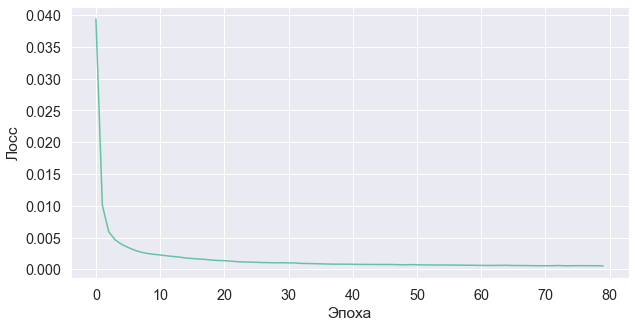

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

lstm_model, _ = train_ts_model(lstm_model, criterion, optimizer, train_batch_gen, num_epochs=80);

In [16]:
start_seq = train_data_normalized[-n_past:]
lstm_result = evaluate_ts_model(lstm_model, start_seq, test_data_normalized)

In [17]:
lstm_result = np.array(lstm_result, ndmin=2)
lstm_result = scaler.inverse_transform(lstm_result)

In [18]:
y_truth = test_data['Consumption']
rmse = np.sqrt(((lstm_result[:, 0] - y_truth) ** 2).mean())
print('RMSE на тестовых данных = {:.3f}'.format(rmse))

RMSE на тестовых данных = 747.292


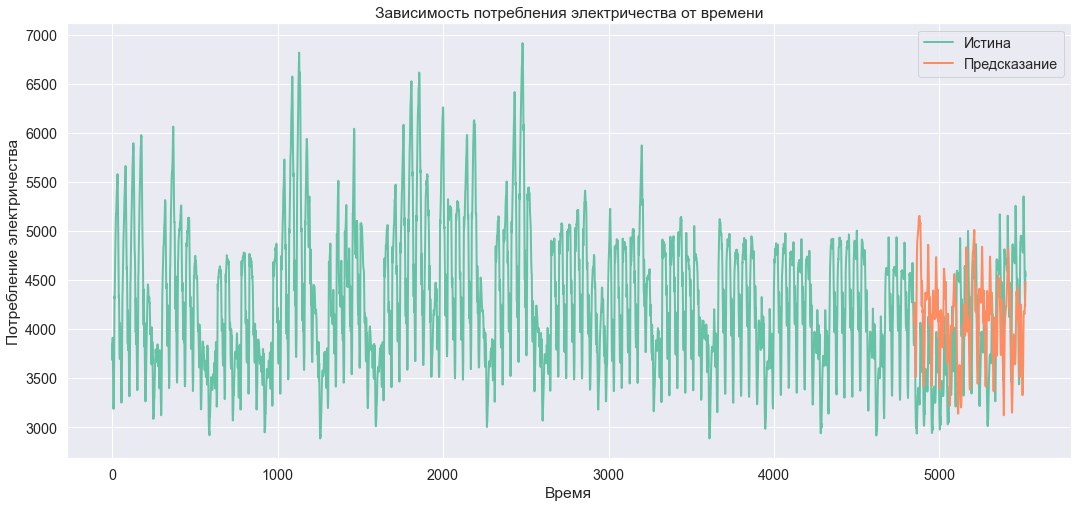

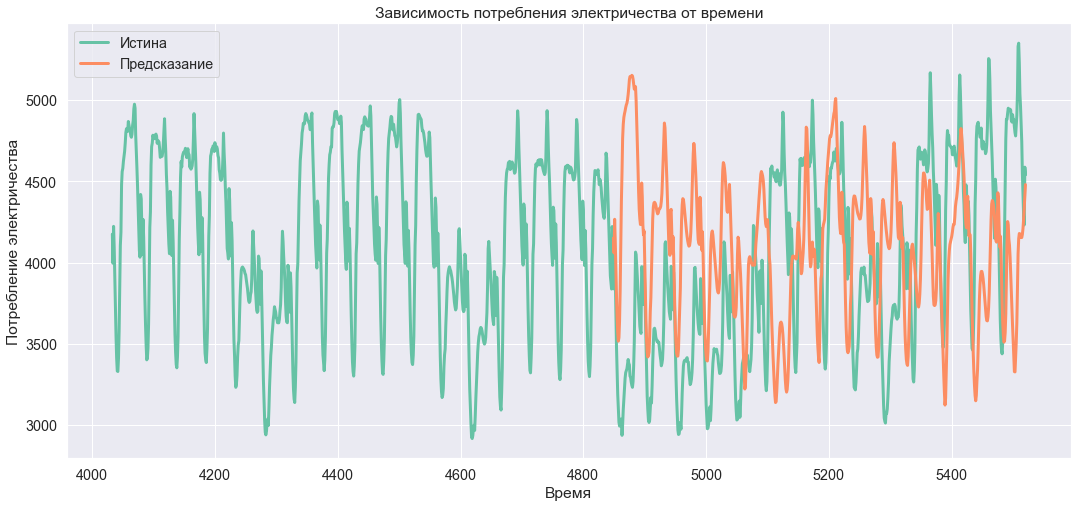

In [22]:
plot_ts_results(lstm_result)
plot_ts_results(lstm_result, show_from=48*14*6, lw=3)

Реализуйте процедуру дообучения модели описанным далее способом для
* $h = 48\times7\ измерений = 7\ суток$ &mdash; горизонт прогнозирования;
* $\tau = 24\ измерения = 12\ часов$ &mdash; периодичность дообучения.

Пусть мы находимся в момент времени $T$ и уже обучили модель на всех имеющихся данных до момента времени $T$. Тогда необходимо выполнить следующие шаги.
1. Построить прогнозы на $h$ измерений вперед по одному наблюдению рекурсивно.
2. Подождать, пока поступят следующие $\tau$ измерений, и добавить их к обучающей выборке.
3. При необходимости удалить из обучающей выборки несколько старых измерений.
4. Произвести несколько итераций backpropagation для имеющейся нейронной сети и вернуться к шагу 1.


После каждой итерации рисуйте график, на котором отображены:
* обучающая и тестовая часть данных разными цветами;
* прогнозы на данной итерации;
* текущий момент времени вертикальной пунктирной линией.

Кроме того, после каждой итерации посчитайте ошибку прогнозирования по метрикам RMSE, MAE, MAPE на длину горизонта прогнозирования $h$ и только на $\tau$ измерений. Постройте графики изменения ошибок при дообучении модели.

Для экспериментов полезно использовать
* `IPython.display.clear_output(wait=True)` &mdash; непосредственно до начала отрисовки каждого графика для его непрерывного обновления, **отключите эту команду при финальном запуске перед отправкой на проверку**;
* `time.sleep(some_seconds)` &mdash; визуальная задержка в момент поступления новых данных.



In [62]:
def smart_evaluate_ts_model(model, first_train_data, all_test_data, train_normalized, tau=24, h=48*7, sleep_time=0.3):
    metrics = {'rmse_h' : [], 'rmse_t' : [], 'mae_h' : [], 'mae_t' : [], 'mape_h' : [], 'mape_t' : []}

    data = pd.concat([first_train_data, all_test_data])
    for num_period in range(h // tau):
        start_time = time.time()
        input_tensor = torch.FloatTensor(train_normalized).to(device).unsqueeze(0)
        model.eval()
        result = []
        with torch.no_grad():
            for i in range(h):
                logits = model(input_tensor[:, i:, :]).unsqueeze(0)
                input_tensor = torch.cat((input_tensor, logits), 1)
                result.append(logits.cpu().numpy().squeeze())
       
        time.sleep(sleep_time)
        train_data = data.iloc[:len(first_train_data) + tau * (num_period + 1)]
        test_data = data.iloc[len(first_train_data) + tau * (num_period + 1): len(first_train_data) + tau * (num_period + 1) + h]
        scaler = MinMaxScaler(feature_range=(-1, 1))
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)
        train_batch_gen = DataLoader(train_dataset, batch_size, shuffle=False)
        
        model, _ = train_ts_model(model, criterion, optimizer, train_batch_gen, num_epochs=10, graphic=False)
        y_truth = test_data[['Consumption']]
        result = np.array(result, ndmin=2)
        result = scaler.inverse_transform(result)
        result = result[:, 0]
        
        metrics['rmse_h'].append(np.sqrt(mean_squared_error(y_truth, result)))
        metrics['rmse_t'].append(np.sqrt(mean_squared_error(y_truth[:tau], result[:tau])))
        metrics['mae_h'].append(np.sqrt(mean_absolute_error(y_truth, result)))
        metrics['mae_t'].append(np.sqrt(mean_absolute_error(y_truth[:tau], result[:tau])))
        metrics['mape_h'].append(np.sqrt(mean_absolute_percentage_error(y_truth, result)))
        metrics['mape_t'].append(np.sqrt(mean_absolute_percentage_error(y_truth[:tau], result[:tau])))

#         clear_output(wait=True)
        
        plt.figure(figsize=(18, 8))
        plt.title('Зависимость потребления электричества от времени')
        plt.plot(train_data.index,
                 train_data.Consumption, label='Трейн', lw=3)
        plt.plot(test_data.index,
                 test_data.Consumption, label='Тест', lw=3)

        plt.plot(test_data.index, result, label='Предсказание', lw=3)

        plt.xlabel('Время')
        plt.ylabel('Потребление электричества')
        plt.legend()
        plt.show()

        delta = time.time() - start_time
        print(f'итерация {num_period} из {h // tau} выполнена за {delta} секунд')
        
    return metrics

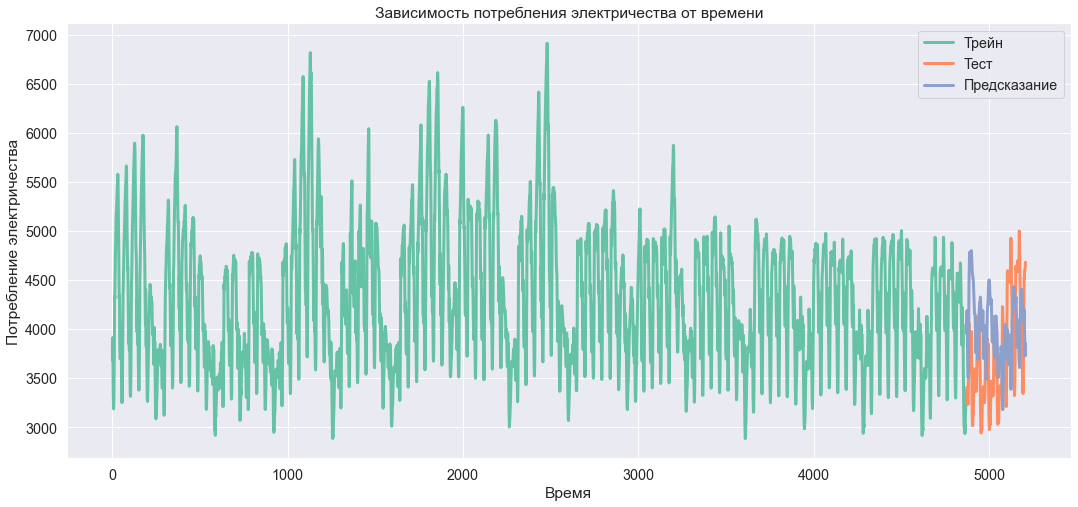

итерация 0 из 14 выполнена за 51.0593740940094 секунд


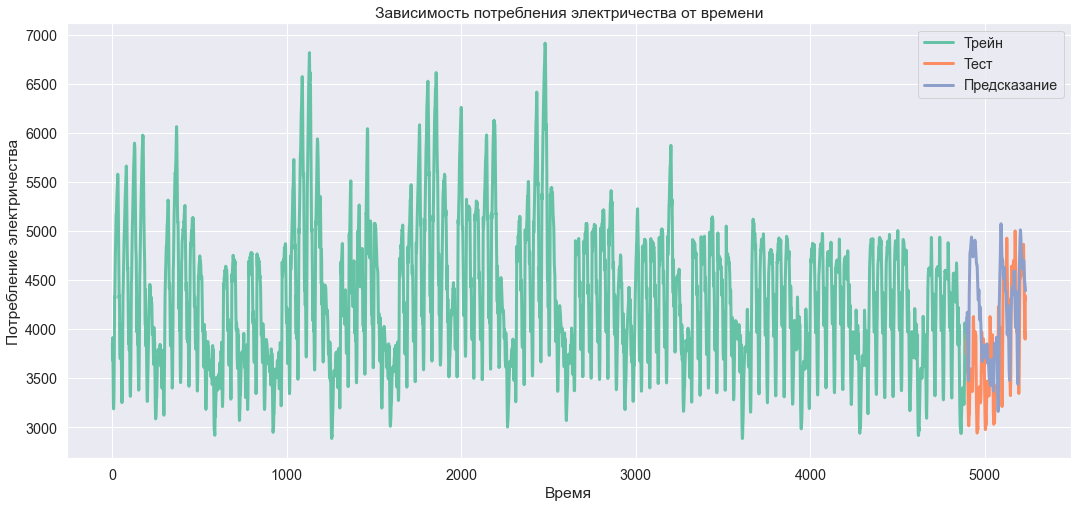

итерация 1 из 14 выполнена за 51.44126033782959 секунд


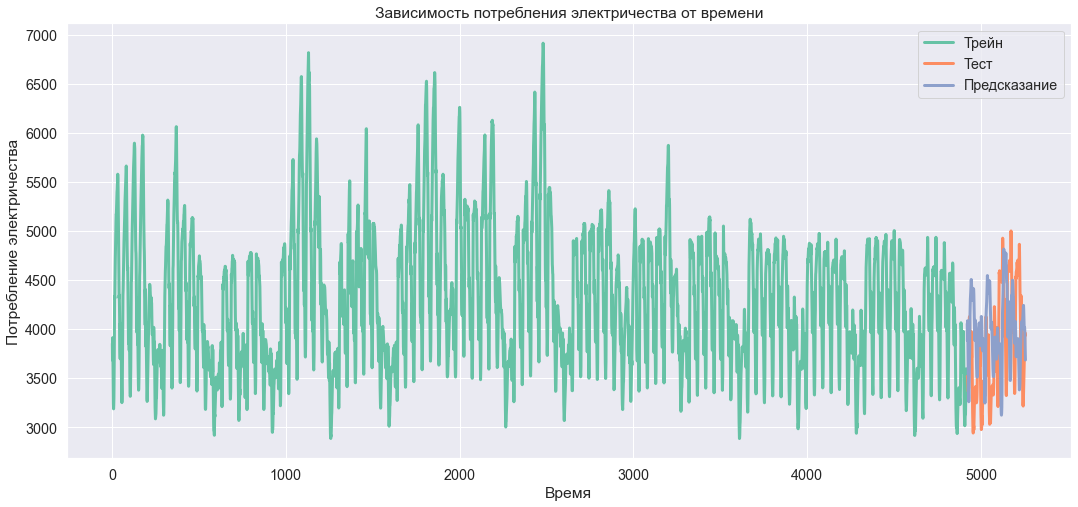

итерация 2 из 14 выполнена за 51.17487382888794 секунд


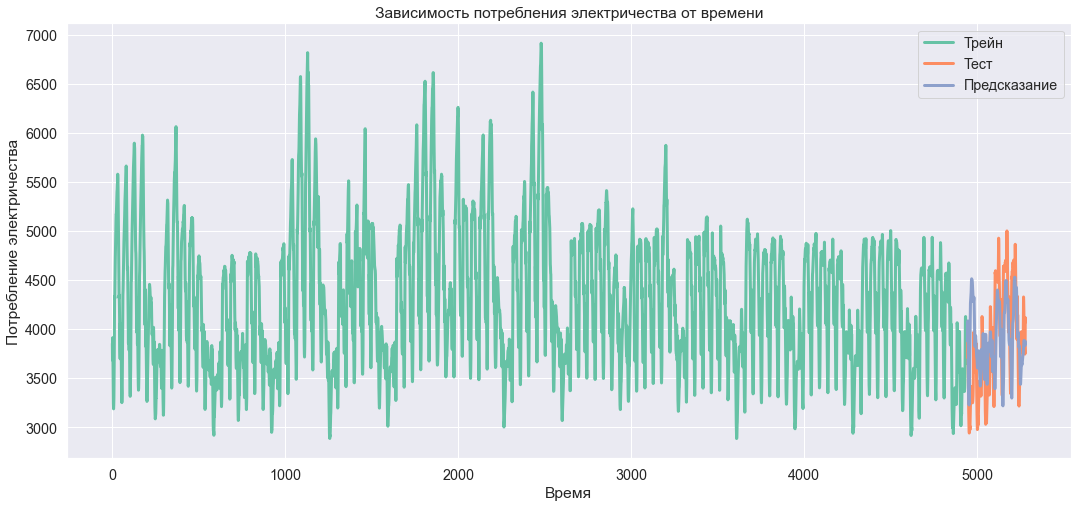

итерация 3 из 14 выполнена за 51.25121474266052 секунд


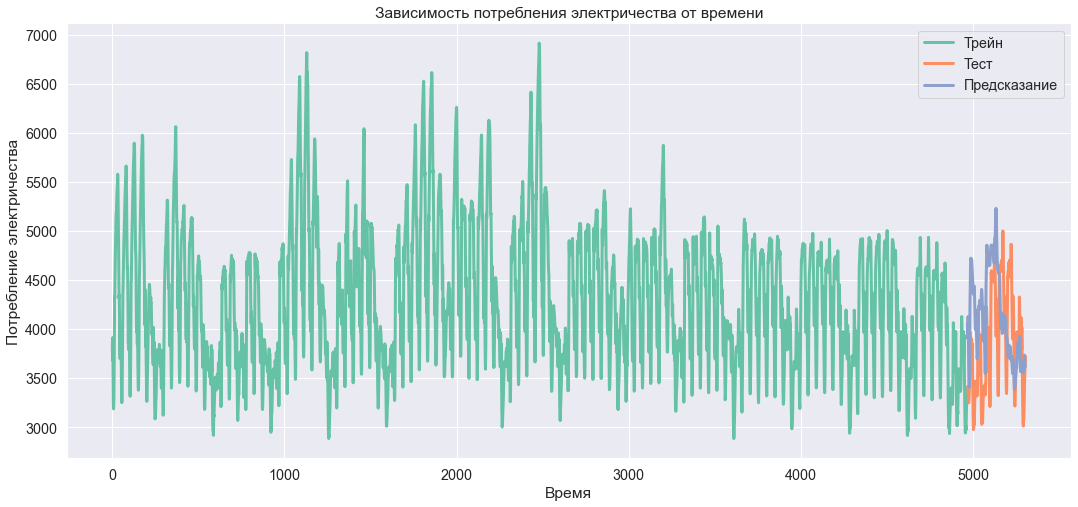

итерация 4 из 14 выполнена за 51.13341760635376 секунд


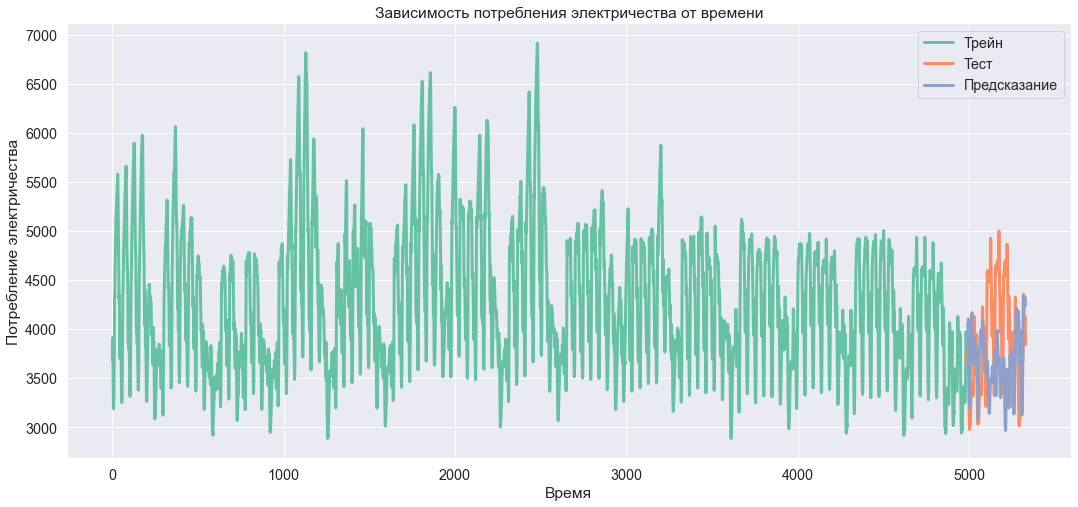

итерация 5 из 14 выполнена за 51.16482973098755 секунд


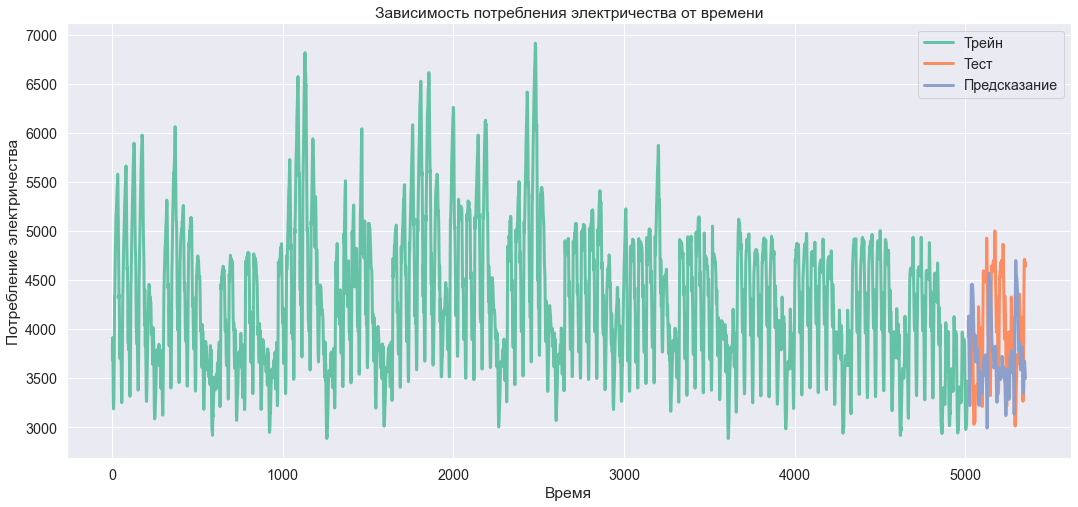

итерация 6 из 14 выполнена за 51.81107425689697 секунд


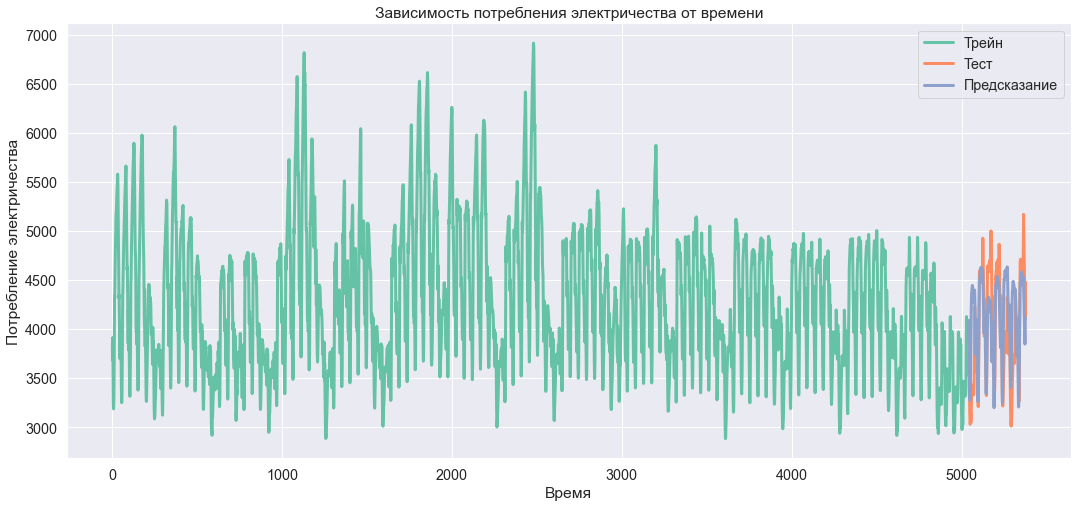

итерация 7 из 14 выполнена за 51.19477415084839 секунд


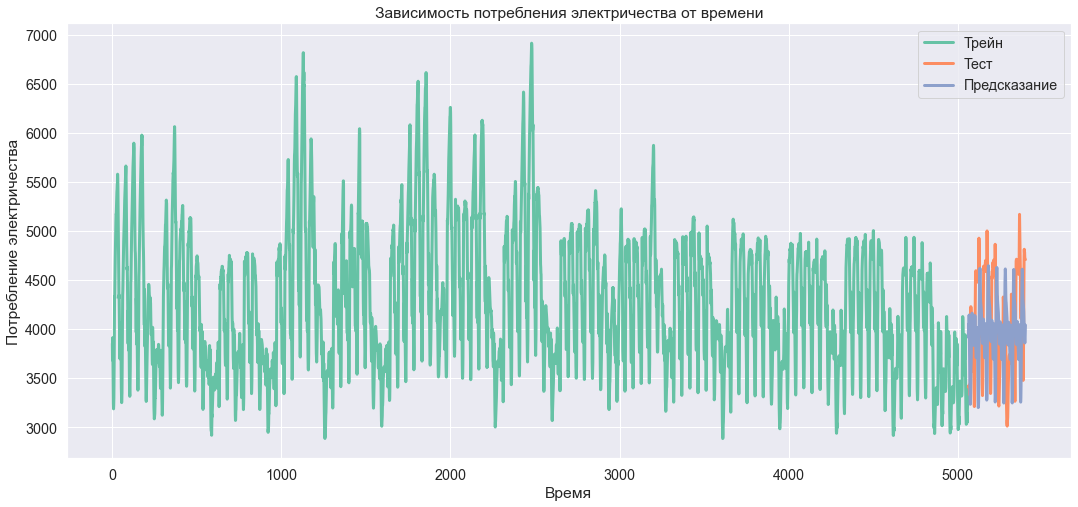

итерация 8 из 14 выполнена за 51.2650990486145 секунд


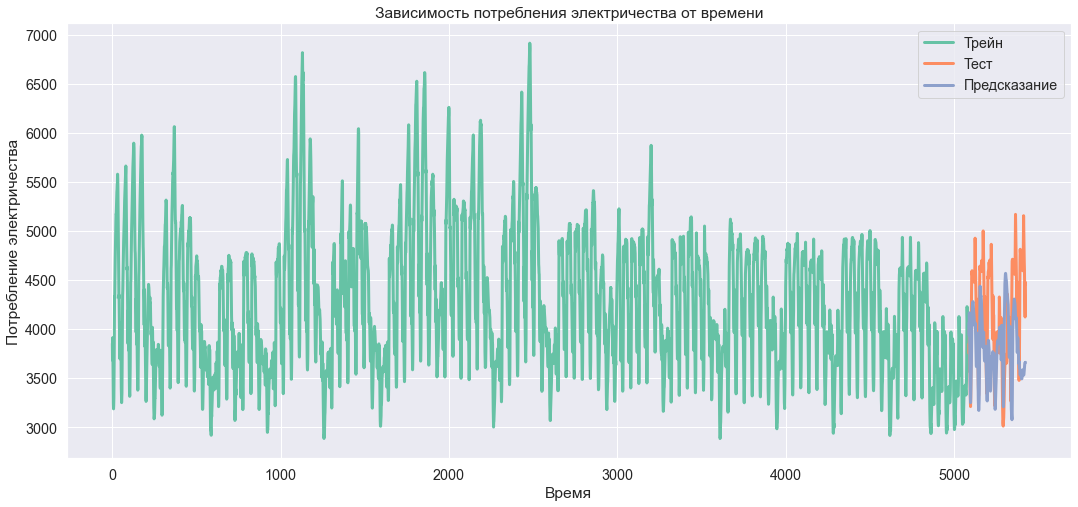

итерация 9 из 14 выполнена за 52.378429651260376 секунд


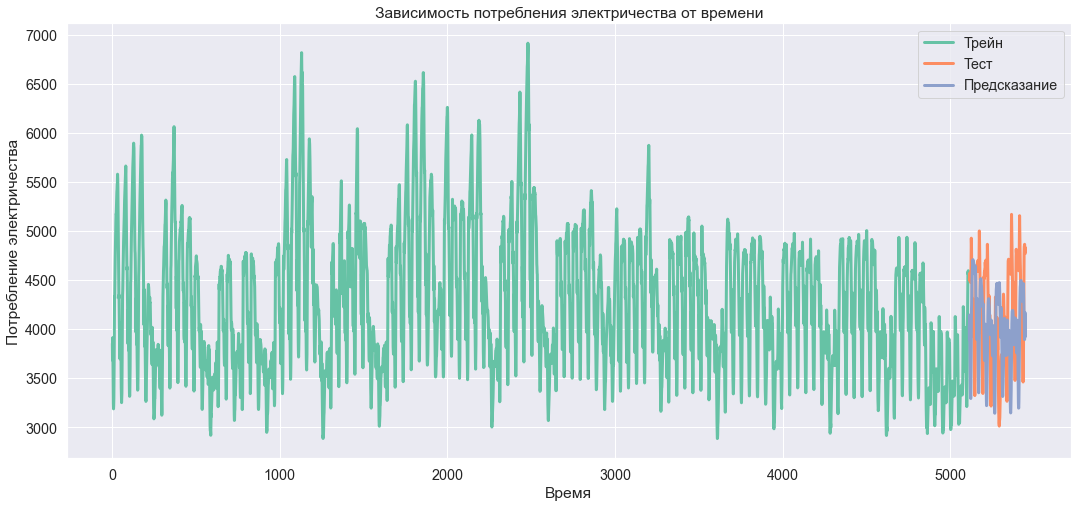

итерация 10 из 14 выполнена за 51.16252660751343 секунд


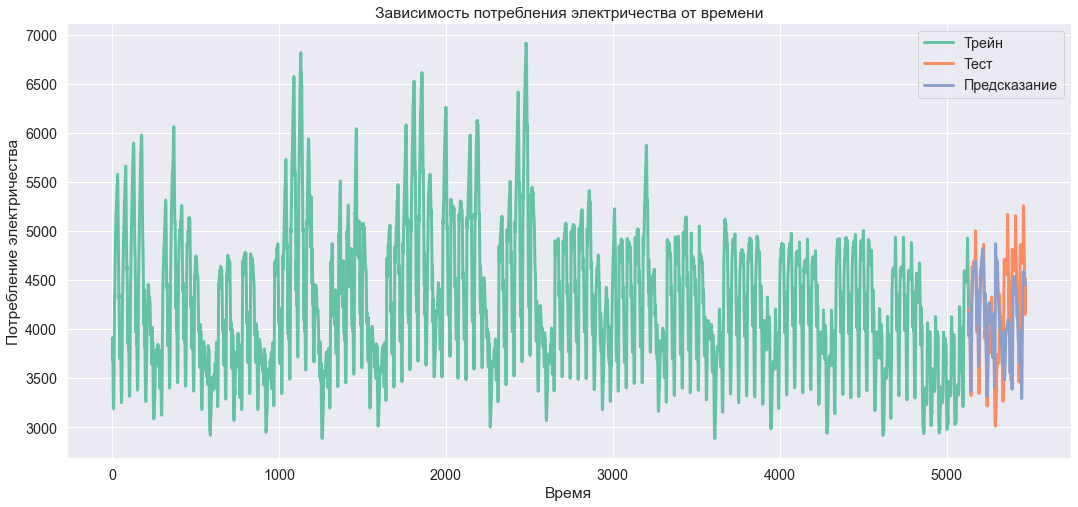

итерация 11 из 14 выполнена за 51.26347303390503 секунд


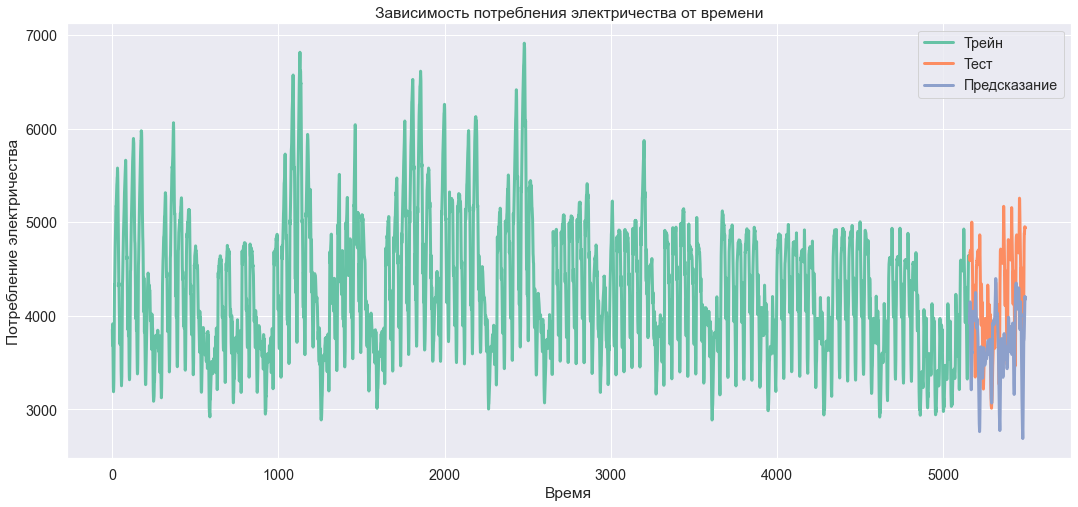

итерация 12 из 14 выполнена за 51.40958905220032 секунд


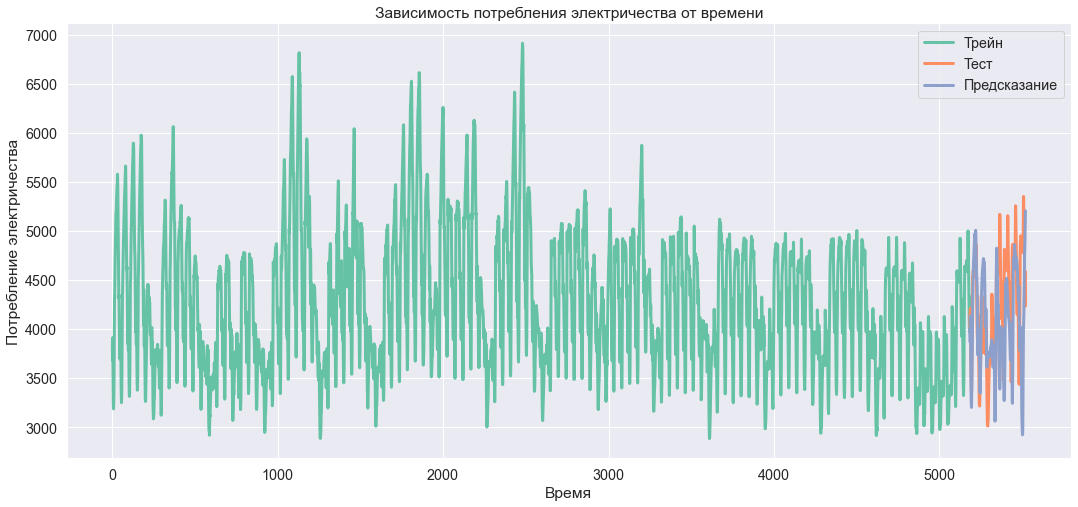

итерация 13 из 14 выполнена за 51.070000648498535 секунд
CPU times: total: 11min 52s
Wall time: 11min 58s


In [63]:
%%time
metrics = smart_evaluate_ts_model(lstm_model, train_data, test_data, train_data_normalized)

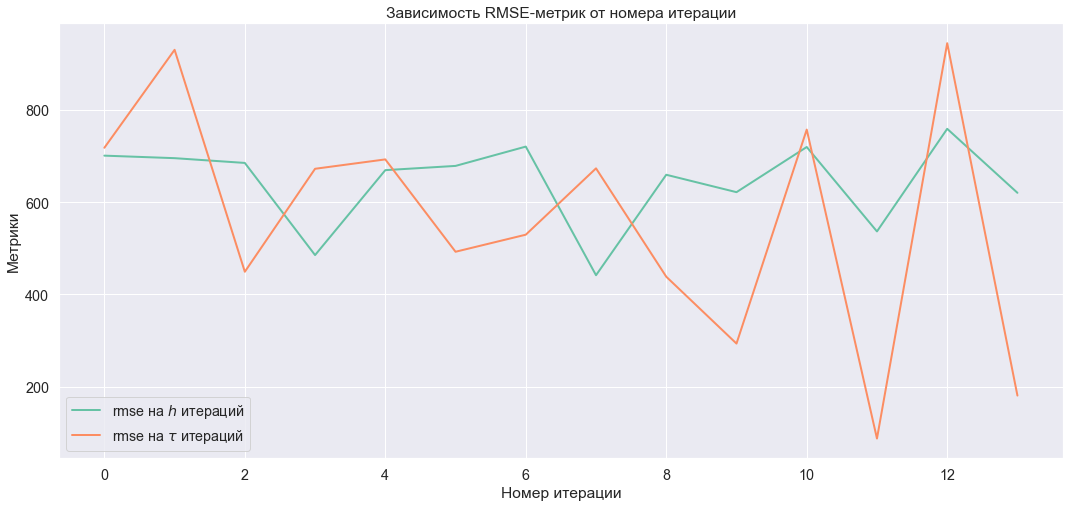

In [64]:
fontsize = 16
plt.figure(figsize=(18, 8))
plt.title('Зависимость RMSE-метрик от номера итерации')
plt.plot(metrics['rmse_h'], label='rmse на $h$ итераций', lw=2)
plt.plot(metrics['rmse_t'], label='rmse на $\\tau$ итераций', lw=2)
plt.xlabel('Номер итерации')
plt.ylabel('Метрики')
plt.legend()
plt.show()

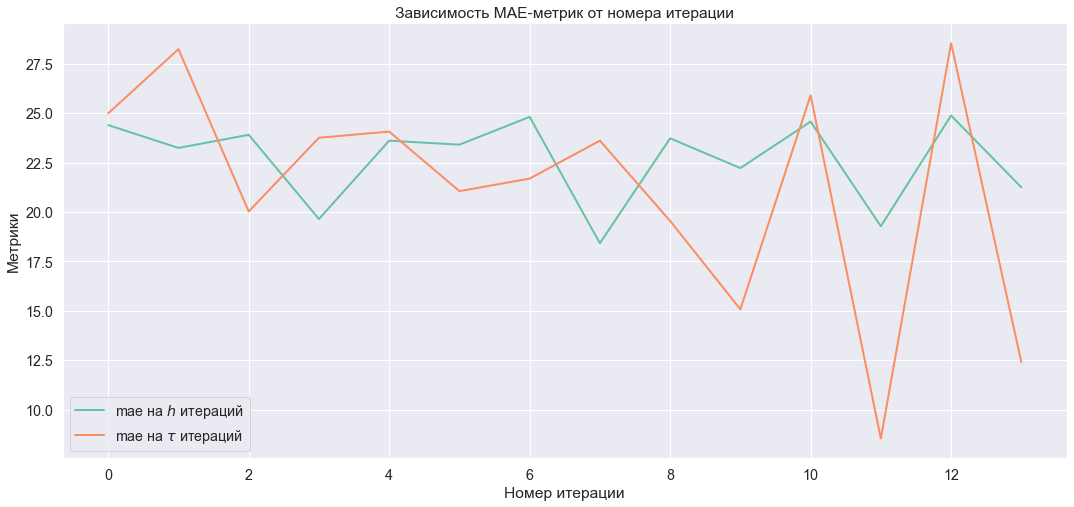

In [65]:
fontsize = 16
plt.figure(figsize=(18, 8))
plt.title('Зависимость MAE-метрик от номера итерации')
plt.plot(metrics['mae_h'], label='mae на $h$ итераций', lw=2)
plt.plot(metrics['mae_t'], label='mae на $\\tau$ итераций', lw=2)
plt.xlabel('Номер итерации')
plt.ylabel('Метрики')
plt.legend()
plt.show()

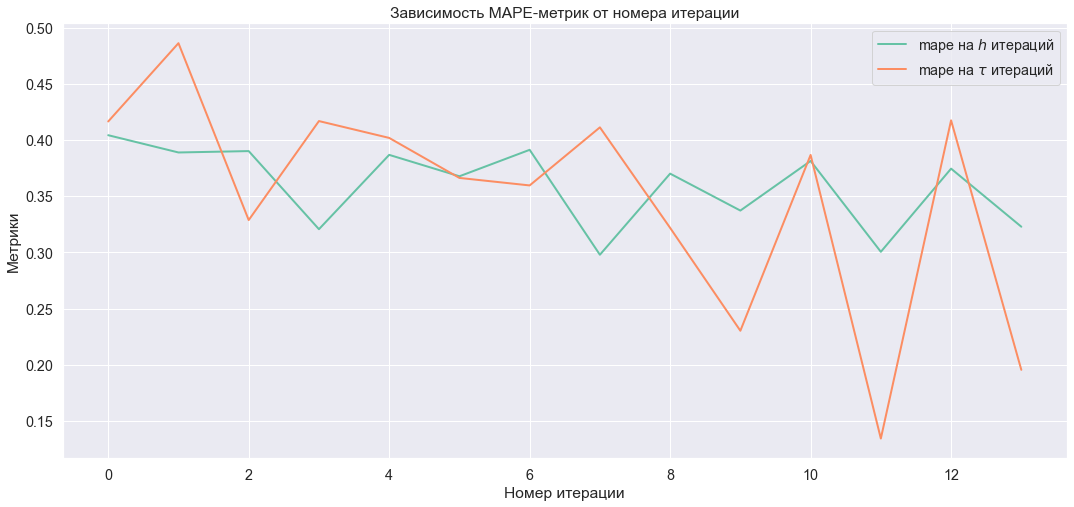

In [66]:
fontsize = 16
plt.figure(figsize=(18, 8))
plt.title('Зависимость MAPE-метрик от номера итерации')
plt.plot(metrics['mape_h'], label='mape на $h$ итераций', lw=2)
plt.plot(metrics['mape_t'], label='mape на $\\tau$ итераций', lw=2)
plt.xlabel('Номер итерации')
plt.ylabel('Метрики')
plt.legend()
plt.show()

In [70]:
print(f'RMSE модели, предсказывающей сразу на 2 недели: {rmse}')
print(f'''среднее RMSE по предсказаниям на неделю: {np.mean(metrics['rmse_h'])}''')
print(f'''среднее RMSE по предсказаниям на 12 часов: {np.mean(metrics['rmse_t'])}''')

RMSE модели, предсказывающей сразу на 2 недели: 747.2921328123313
среднее RMSE по предсказаниям на неделю: 642.5364379461662
среднее RMSE по предсказаниям на 12 часов: 561.5452627617141


Сделайте выводы.

Как видно из полученных результатов, чем чаще мы переобучаемся и чем на меньший период предсказываем, тем, в основном, точнее получаются предсказания. Так, например, предсказание на 2 недели можно составить из предсказаний на неделю первой модели и предсказания на неделю модели, обученной с учетом прошедшей недели, а можно переобучать модель, с периодичностью в 12 часов, и, скорее всего, результат у второй модели будет точнее, а результат у первой &mdash; точнее, чем результат модели, которая сразу предсказывает на 2 недели. Также стоит отметить, что нет монотонного убывания метрик в зависимости от номера итерации. Это происходит потому, что мы предсказываем на периоды одинаковой длины, лишь немного увеличивая размер трейновой выборки, что, конечно, в среднем нам немного помогает, однако на практике видна сильная зависимость от распределения данных на предсказываемый период.